# **FULL DATASET BINARY**

### **Preliminary steps**

In [1]:
import os 
print(os.getcwd())
os.chdir('../..')
print(os.getcwd())

/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp/analysis/notebooks
/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp


In [2]:
### PACKAGES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [3]:
### FUNCTIONS

from src.configs import constants, ml_config, names
from src.libs import preprocessing, evaluation, visualization

In [4]:
import importlib
importlib.reload(preprocessing)

<module 'src.libs.preprocessing' from '/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp/src/libs/preprocessing.py'>

In [5]:
### LOAD DATA

df_poetry_gpt = preprocessing.load_dataset(source="GPT", type="POETRY")
df_poetry_bard = preprocessing.load_dataset(source="BARD", type="POETRY")
df_poetry_human = preprocessing.load_dataset(source="Human", type="POETRY")

df_essay_gpt = preprocessing.load_dataset(source="GPT", type="ESSAY")
df_essay_bard = preprocessing.load_dataset(source="BARD", type="ESSAY")
df_essay_human = preprocessing.load_dataset(source="Human", type="ESSAY")

df_story_gpt = preprocessing.load_dataset(source="GPT", type="STORY")
df_story_bard = preprocessing.load_dataset(source="BARD", type="STORY")
df_story_human = preprocessing.load_dataset(source="Human", type="STORY")

Time taken to load dataset: 0.02680206298828125 seconds
Time taken to load dataset: 0.0055730342864990234 seconds
Time taken to load dataset: 0.25193214416503906 seconds
Time taken to load dataset: 0.007601022720336914 seconds
Time taken to load dataset: 0.005705833435058594 seconds
Time taken to load dataset: 0.06920409202575684 seconds
Time taken to load dataset: 0.008440732955932617 seconds
Time taken to load dataset: 0.008300065994262695 seconds
Time taken to load dataset: 0.00943899154663086 seconds


In [6]:
### GROUPED LLM 
df_poetry = preprocessing.get_poetry_dataset(
        df_poetry_gpt,
        df_poetry_bard,
        df_poetry_human,
        samples_per_source=min(
            len(df_poetry_gpt),
            len(df_poetry_bard),
            len(df_poetry_human),
        ),
    )

df_essay = preprocessing.get_essay_dataset(
        df_essay_gpt,
        df_essay_bard,
        df_essay_human,
        samples_per_source=min(
            len(df_essay_gpt), len(df_essay_bard), len(df_essay_human)
        ),
    )

df_story = preprocessing.get_story_dataset(
        df_story_gpt,
        df_story_bard,
        df_story_human,
        samples_per_source=min(
            len(df_story_gpt), len(df_story_bard), len(df_story_human)
        ),
    )


# ### GROUPED LLM 
# df_poetry = preprocessing.get_poetry_dataset(
#         df_poetry_gpt,
#         df_poetry_bard,
#         df_poetry_human,
#         samples_per_source=None,
#     )

# df_essay = preprocessing.get_essay_dataset(
#         df_essay_gpt,
#         df_essay_bard,
#         df_essay_human,
#         samples_per_source=None,
#     )

# df_story = preprocessing.get_story_dataset(
#         df_story_gpt,
#         df_story_bard,
#         df_story_human,
#         samples_per_source=None,
#     )



In [7]:
def group_llm(df):
    df["origin"] = df["label"]
    df["label"] = (df["label"] > 0).astype(int)
    return df

In [8]:
### GROUP 
df_poetry = group_llm(df_poetry)
df_essay = group_llm(df_essay)
df_story = group_llm(df_story)

In [9]:
### GET TRAIN SPLIT

df_train_poetry, df_test_poetry = preprocessing.train_valid_split(df_poetry)
df_train_essay, df_test_essay = preprocessing.train_valid_split(df_essay)
df_train_story, df_test_story = preprocessing.train_valid_split(df_story)

df_train_poetry_gpt, df_test_poetry_gpt = df_train_poetry[df_train_poetry.label==1].copy(), df_test_poetry[df_test_poetry.label==1].copy()
df_train_poetry_bard, df_test_poetry_bard = df_train_poetry[df_train_poetry.label==2].copy(), df_test_poetry[df_test_poetry.label==2].copy()
df_train_poetry_human, df_test_poetry_human = df_train_poetry[df_train_poetry.label==0].copy(), df_test_poetry[df_test_poetry.label==0].copy()


df_train_story_gpt, df_test_story_gpt = df_train_story[df_train_story.label==1].copy(), df_test_story[df_test_story.label==1].copy()
df_train_story_bard, df_test_story_bard = df_train_story[df_train_story.label==2].copy(), df_test_story[df_test_story.label==2].copy()
df_train_story_human, df_test_story_human = df_train_story[df_train_story.label==0].copy(), df_test_story[df_test_story.label==0].copy()

df_train_essay_gpt, df_test_essay_gpt = df_train_essay[df_train_essay.label==1].copy(), df_test_essay[df_test_essay.label==1].copy()
df_train_essay_bard, df_test_essay_bard = df_train_essay[df_train_essay.label==2].copy(), df_test_essay[df_test_essay.label==2].copy()
df_train_essay_human, df_test_essay_human = df_train_essay[df_train_essay.label==0].copy(), df_test_essay[df_test_essay.label==0].copy()

In [10]:
### CONCATENATE ALL DATASETS

df_train = pd.concat([df_train_poetry, df_train_essay, df_train_story], axis=0).sample(
    frac=1
)
df_test = pd.concat([df_test_poetry, df_test_essay, df_test_story], axis=0).sample(
    frac=1
)

In [11]:
### SPLIT FEATURES AND LABELS

X_train, y_train = preprocessing.split_features_and_labels(df_train)
X_test, y_test = preprocessing.split_features_and_labels(df_test)
X_test_poetry, y_test_poetry = preprocessing.split_features_and_labels(df_test_poetry)
X_test_essay, y_test_essay = preprocessing.split_features_and_labels(df_test_essay)
X_test_story, y_test_story = preprocessing.split_features_and_labels(df_test_story)

## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [12]:
df_train_essay.label.value_counts(), df_test_essay.label.value_counts()

(label
 1    276
 0    139
 Name: count, dtype: int64,
 label
 1    120
 0     59
 Name: count, dtype: int64)

In [13]:
df_train_poetry.label.value_counts(), df_test_poetry.label.value_counts()

(label
 1    352
 0    173
 Name: count, dtype: int64,
 label
 1    148
 0     77
 Name: count, dtype: int64)

In [14]:
df_train_story.label.value_counts(), df_test_story.label.value_counts()

(label
 1    133
 0     66
 Name: count, dtype: int64,
 label
 1    57
 0    29
 Name: count, dtype: int64)

In [15]:
def punctuation_transform(X: np.ndarray) -> np.ndarray:

    X_series = pd.Series(X).astype(str)
    array_nb_characters = X_series.str.len().to_numpy()

    array_ratio_punctuations = (
        X_series.str.count(r"[^\w\s]").to_numpy() / array_nb_characters
    )
    array_ratio_words_per_sentence = (
        X_series.str.count(r"[.!?]").to_numpy()
        / X_series.str.split().str.len().to_numpy()
    )
    array_ratio_odd_characters = (
        X_series.str.count(r"[!;-_]").to_numpy() / array_nb_characters
    )

    embedding = pd.DataFrame(
        {
            "ratio_punctuations": array_ratio_punctuations,
            "ratio_words_per_sentence": array_ratio_words_per_sentence,
            "ratio_odd_characters": array_ratio_odd_characters,
        }
    ).to_numpy()

    return embedding

def punctuation_map_dimensions_to_names() -> np.ndarray:
    return np.array([
        "ratio_punctuations",
        "ratio_words_per_sentence",
        "ratio_odd_characters"
    ])


In [16]:
### EMBEDDING

X_train_211 = punctuation_transform(X_train)
X_test_211 = punctuation_transform(X_test)
X_test_poetry_211 = punctuation_transform(X_test_poetry)
X_test_essay_211 = punctuation_transform(X_test_essay)
X_test_story_211 = punctuation_transform(X_test_story)

In [17]:
def evaluate(model, X, y):
    """
    Evaluate a model and return confusion matrix + precision, recall, f1.

    Args:
        model: Trained sklearn-like model.
        X (np.ndarray): Input features.
        y (np.ndarray): True labels.

    Returns:
        dict: Dictionary containing confusion matrix, precision, recall, f1 score.
    """
    y_pred = model.predict(X)

    return {
        "confusion_matrix": confusion_matrix(y, y_pred),
        "precision": precision_score(y, y_pred, average="binary"),
        "recall": recall_score(y, y_pred, average="binary"),
        "f1": f1_score(y, y_pred, average="binary")
    }


In [18]:
### Random search 

param_distributions = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "bootstrap": [True, False],
}

base_rf = RandomForestClassifier(n_jobs=-1, random_state=42)


search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_211, y_train)

best_rf = search.best_estimator_

print("Best hyperparameters:", search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 239}


In [19]:
### CLASSIFIER

best_rf.fit(X_train_211, y_train)


# Evaluation
metrics_211 = evaluate(best_rf, X_test_211, y_test)
metrics_poetry_211 = evaluate(best_rf, X_test_poetry_211, y_test_poetry)
metrics_essay_211 = evaluate(best_rf, X_test_essay_211, y_test_essay)
metrics_story_211 = evaluate(best_rf, X_test_story_211, y_test_story)

results = {
    "test": metrics_211,
    "poetry": metrics_poetry_211,
    "essay": metrics_essay_211,
    "story": metrics_story_211
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


              confusion_matrix precision    recall        f1
test    [[119, 46], [38, 287]]  0.861862  0.883077   0.87234
poetry   [[65, 12], [13, 135]]  0.918367  0.912162  0.915254
essay    [[36, 23], [18, 102]]     0.816      0.85  0.832653
story      [[18, 11], [7, 50]]  0.819672  0.877193  0.847458


In [20]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = punctuation_map_dimensions_to_names()
feature_importances_211 = best_rf.feature_importances_

most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]

for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")


ratio_words_per_sentence: 0.37808354876656225
ratio_odd_characters: 0.33973277620287556
ratio_punctuations: 0.2821836750305623


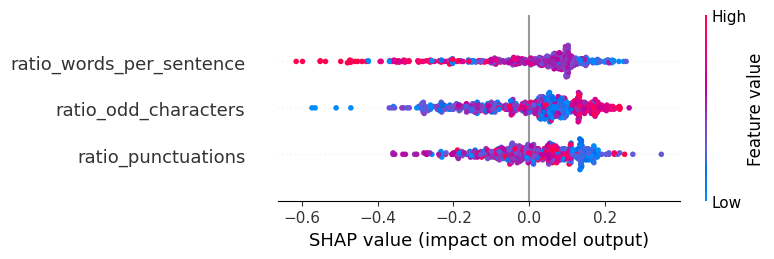

In [21]:
### INTERPRETABILITY - SHAP VALUES

explainer_211 = shap.Explainer(best_rf)
X_test_211_dense = X_test_211
shap_values_211 = explainer_211(X_test_211_dense)

shap.summary_plot(
    shap_values_211.values[:, :, 1], 
    features=X_test_211_dense,
    feature_names=dim_names_211
)

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [22]:
def fit_tfidf_embedding(X_train_texts, max_features=1000):
    """
    Fit a TF-IDF vectorizer on training texts.

    Args:
        X_train_texts (list or np.ndarray): Training texts.
        max_features (int): Maximum number of features for TF-IDF.

    Returns:
        vectorizer: Fitted TfidfVectorizer instance.
        X_train_tfidf: Transformed training data.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        smooth_idf=True,
        stop_words="english"
    )
    X_train_tfidf = vectorizer.fit_transform(X_train_texts)
    return vectorizer, X_train_tfidf

def transform_with_tfidf(vectorizer, X_texts):
    """
    Transform texts using an already fitted TF-IDF vectorizer.

    Args:
        vectorizer: A fitted TfidfVectorizer.
        X_texts (list or np.ndarray): Texts to transform.

    Returns:
        X_tfidf: Transformed TF-IDF matrix.
    """
    return vectorizer.transform(X_texts)


In [23]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

In [24]:
base_rf = RandomForestClassifier(n_jobs=-1, random_state=42)


search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_tfidf, y_train)

best_rf_tfidf = search.best_estimator_

print("Best hyperparameters:", search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


In [25]:
### CLASSIFIER

best_rf_tfidf.fit(X_train_tfidf, y_train)

# Evaluation
metrics_tfidf = evaluate(best_rf_tfidf, X_test_tfidf, y_test)
metrics_poetry_tfidf = evaluate(best_rf_tfidf, X_test_poetry_tfidf, y_test_poetry)
metrics_essay_tfidf = evaluate(best_rf_tfidf, X_test_essay_tfidf, y_test_essay)
metrics_story_tfidf = evaluate(best_rf_tfidf, X_test_story_tfidf, y_test_story)

results = {
    "test": metrics_tfidf,
    "poetry": metrics_poetry_tfidf,
    "essay": metrics_essay_tfidf,
    "story": metrics_story_tfidf
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


             confusion_matrix precision    recall        f1
test    [[130, 35], [5, 320]]  0.901408  0.984615  0.941176
poetry   [[47, 30], [0, 148]]  0.831461       1.0  0.907975
essay     [[57, 2], [1, 119]]  0.983471  0.991667  0.987552
story      [[26, 3], [4, 53]]  0.946429  0.929825  0.938053


In [26]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_tfidf = vectorizer_tfidf.get_feature_names_out()
feature_importances_tfidf = best_rf_tfidf.feature_importances_
most_important_features_tfidf = np.argsort(feature_importances_tfidf)[-20:][::-1]
for i in most_important_features_tfidf:
    print(f"{dim_names_tfidf[i]}: {feature_importances_tfidf[i]:.5f}")


really: 0.03023
like: 0.02596
just: 0.02131
father: 0.01919
going: 0.01915
think: 0.01621
mother: 0.01558
don: 0.01467
says: 0.01366
room: 0.01338
minutes: 0.01238
got: 0.01225
head: 0.01117
man: 0.01020
body: 0.01006
right: 0.00974
maybe: 0.00902
help: 0.00880
guess: 0.00860
half: 0.00859


In [27]:
df_train

,text,abstract,label,type,origin
497,The idea of mandatory military service has bee...,"In many countries, citizens are required to s...",1,essay,2
150,It had stood out to Vio almost immediately. Fr...,"After pretending to join his side, Vio uses Sh...",0,story,0
189,Austin is very different from my home town. I ...,No abstract,0,essay,0
463,Echoes of the Heart The echoes of the heart Re...,Poetry title: Echoes of the Heart,1,poetry,2
710,Among physicians rich in their death watch In ...,\r\r\nfrom Pamphilia to Amphilanthus: Song 5\r...,0,poetry,0
...,...,...,...,...,...
111,"If computers never existed, modern life would ...",Explain how different modern life would be wi...,1,essay,1
580,"Oh, the colors of the flowers Are a sight to b...",write a poem that celebrates the flowers' colors,1,poetry,1
80,"This is different, I always thought stream of ...",No abstract,0,essay,0
159,"The Lie I Believed I believed a lie once, A li...",write a poem about a lie you believed,1,poetry,2


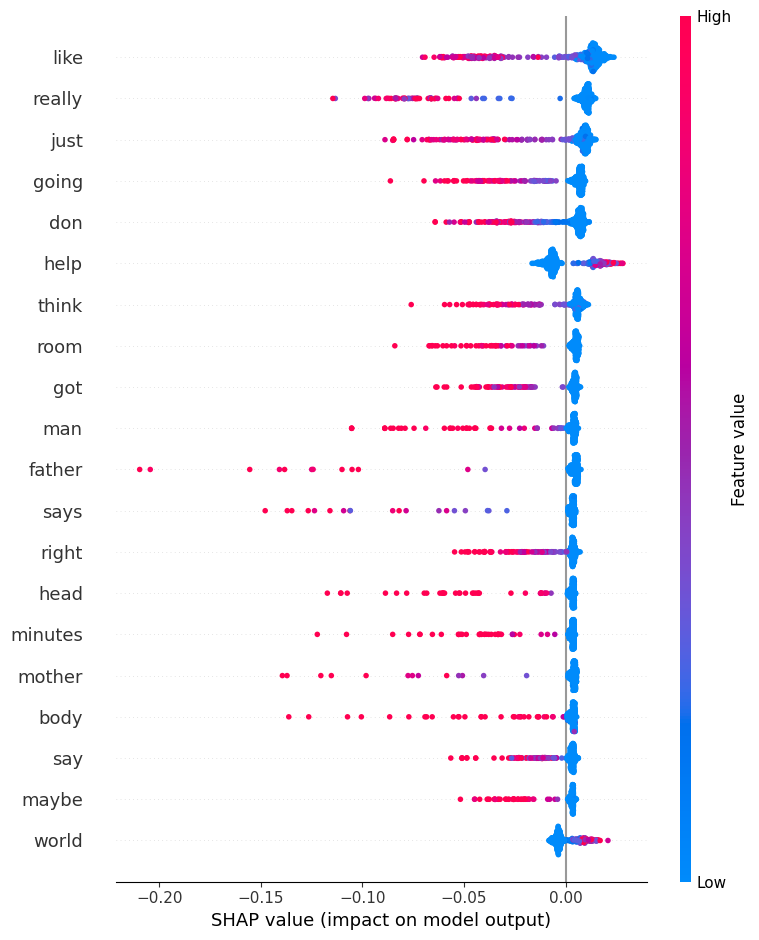

In [28]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(best_rf_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,1],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf
)


## **CLASSIFICATION USING TF-IDF & NAIVE BAYES**

In [29]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

In [30]:
### CLASSIFIER

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

metrics_tfidf = evaluate(nb_classifier, X_test_tfidf, y_test)
metrics_poetry_tfidf = evaluate(nb_classifier, X_test_poetry_tfidf, y_test_poetry)
metrics_essay_tfidf = evaluate(nb_classifier, X_test_essay_tfidf, y_test_essay)
metrics_story_tfidf = evaluate(nb_classifier, X_test_story_tfidf, y_test_story)

results = {
    "test": metrics_tfidf,
    "poetry": metrics_poetry_tfidf,
    "essay": metrics_essay_tfidf,
    "story": metrics_story_tfidf
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


              confusion_matrix precision    recall        f1
test    [[146, 19], [16, 309]]  0.942073  0.950769  0.946401
poetry    [[63, 14], [1, 147]]  0.913043  0.993243  0.951456
essay      [[57, 2], [1, 119]]  0.983471  0.991667  0.987552
story      [[26, 3], [14, 43]]  0.934783  0.754386  0.834951
